# CS 4262: Predicting a Playlist for a Song

<br>by Keshvi Mahalingam, Zinnie Zhang</br>


In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time 
%matplotlib inline

# Run "pip install spotipy" on your local computer
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
# Access Spotify Credentials
client_id = '6d02153904514353ac63fd23acba8d86'
client_secret = '06a9d4ba2e104061b268c6ba7a41c60f'
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [3]:
# Get track ID for a specific user and playlist ID. (Playlist ID found in URL when clicking "share")
# n = number of songs 
def getTrackIDs(user, playlist_id, n = 100):
    ids = []
    playlist = sp.user_playlist(user, playlist_id)
    
    count = 0
    for item in playlist['tracks']['items']:
        track = item['track']
        ids.append(track['id'])
        count += 1
        if count == n: break
        
    return ids

# Get track features
def getTrackFeatures(id):
    meta = sp.track(id)
    features = sp.audio_features(id)

    # meta
    length = meta['duration_ms']
    popularity = meta['popularity']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    key = features[0]['key']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    mode = features[0]['mode']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    time_signature = features[0]['time_signature']
    valence = features[0]['valence']

    track = [length, popularity, acousticness, danceability, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature, valence]
    return track

# Loop track and create dataset
def trackCSV(ids, name):
    tracks = []
    for i in range(len(ids)):
        track = getTrackFeatures(ids[i])
        tracks.append(track)
    
    # create CSV
    df = pd.DataFrame(tracks, columns = ['length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'])
    df.to_csv(name + ".csv", sep = ',')
    print(name + 'CSV created\n')
    
    return df

In [4]:
happyIds = getTrackIDs('xinyizhang.x-ca', '37i9dQZF1DXdPec7aLTmlC')
happy_data = trackCSV(happyIds, 'happy')

sadIds = getTrackIDs('xinyizhang.x-ca', '6nxPNnmSE0d5WlplUsa5L3')
sad_data = trackCSV(sadIds, 'sad')

chillIds = getTrackIDs('xinyizhang.x-ca', '37i9dQZF1DX4WYpdgoIcn6')
chill_data = trackCSV(chillIds, 'chill')


happyCSV created

sadCSV created

chillCSV created



# Exploratory Data Analysis
General Statistics, Correlation Map, Visual Plot of Each Feature, PCA

Happy Songs General Statistics



<AxesSubplot:>

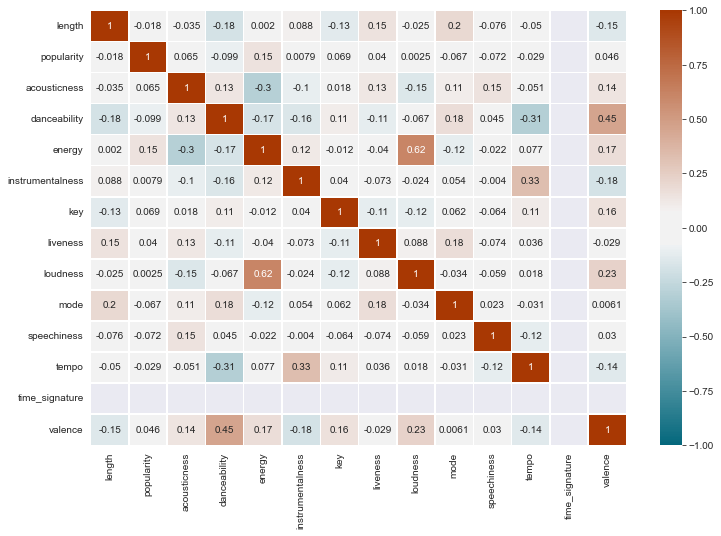

In [5]:
# [length, popularity, acousticness, danceability, energy, instrumentalness, 
# key, liveness, loudness, mode, speechiness, tempo, time_signature, valence]

# General Statistics
print('Happy Songs General Statistics\n')
happy_data.describe()

# Correlation Map
sns.set_style('darkgrid')
plt.figure(figsize = (12,8))
cmap = sns.diverging_palette(220, 20, l = 40, s = 99, sep = 20, center = 'light', as_cmap = True) 
sns.heatmap(happy_data.corr(), vmin = -1, vmax = 1, annot = True, cmap = cmap, lw = .5, linecolor = 'white')


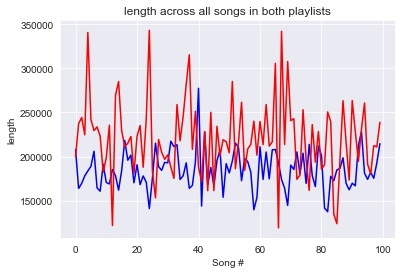

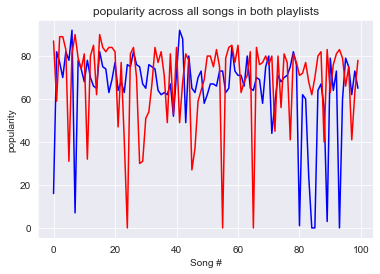

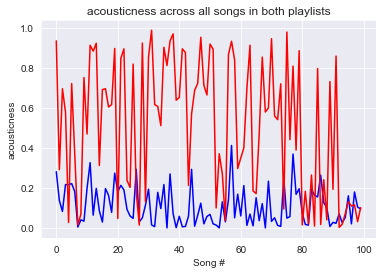

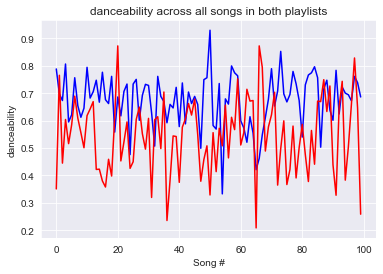

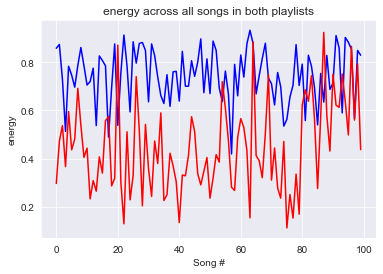

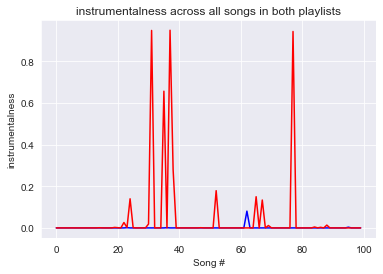

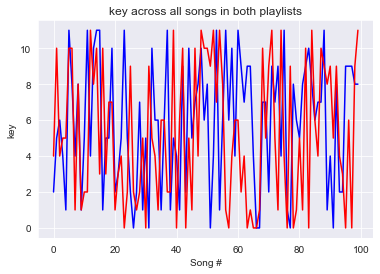

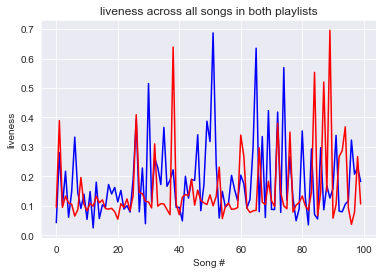

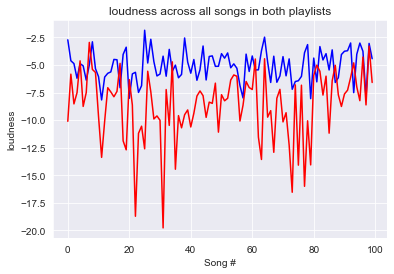

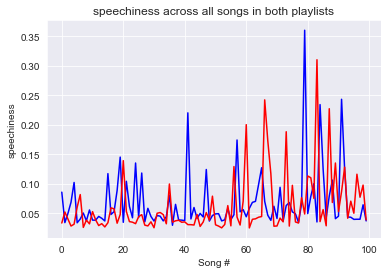

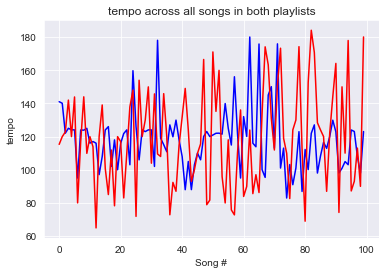

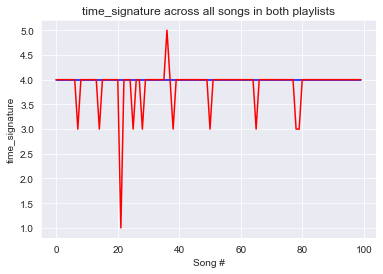

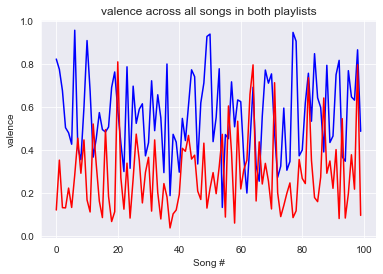

In [6]:
# Plot all features to visually see the greatest seperation
features = ['length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature', 'valence']

for feature in features:
    plt.figure(feature)
    plt.plot(happy_data[feature], color='blue')
    plt.plot(sad_data[feature], color='red')
    plt.xlabel("Song #")
    plt.ylabel(feature)
    plt.title(feature + " across all songs in both playlists")



In [7]:
# Scale data
from sklearn.preprocessing import StandardScaler

# Happy data
scaler = StandardScaler()
scaler.fit(happy_data)
scaled_happy_data = scaler.transform(happy_data)

# Sad data
scaler = StandardScaler()
scaler.fit(sad_data)
scaled_sad_data = scaler.transform(sad_data)

# Combine data
df_scaled_happy = pd.DataFrame(scaled_happy_data, columns = ['length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'])
df_scaled_sad = pd.DataFrame(scaled_sad_data, columns = ['length', 'popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'])
combined = pd.concat([df_scaled_happy, df_scaled_sad])

Text(0, 0.5, 'Ratio of Variance Explained')

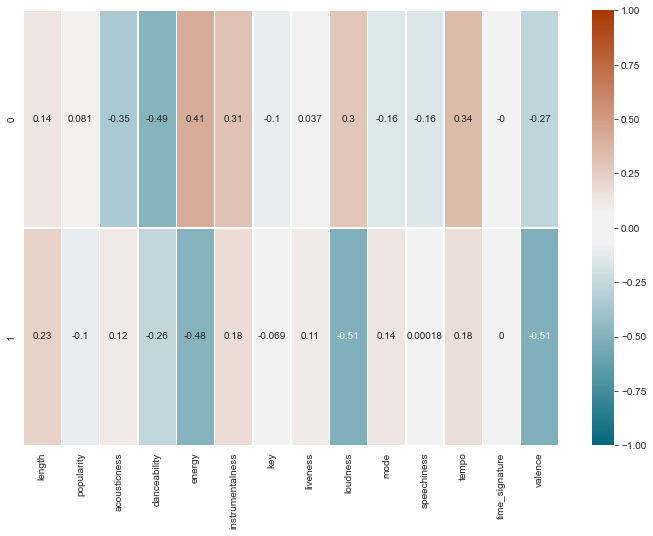

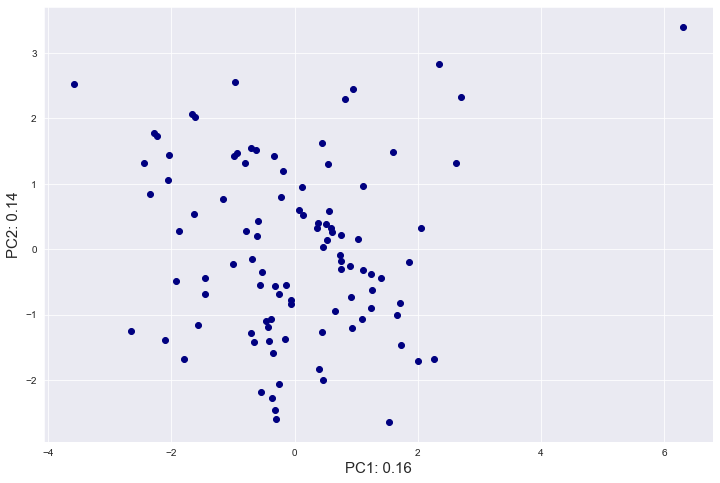

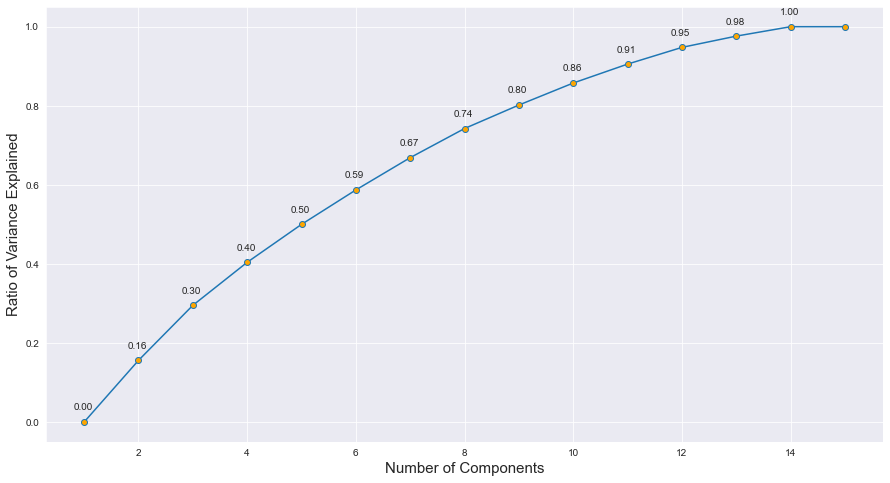

In [8]:
# PCA with 2 components
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(scaled_happy_data)
data_pca = pca.transform(scaled_happy_data)

pca_corr = pd.DataFrame(pca.components_, columns = happy_data.columns)

plt.figure(figsize = (12,8))
sns.heatmap(pca_corr, cmap = cmap, vmin = -1, vmax = 1, annot = True, lw = .5, linecolor = 'white')

plt.figure(figsize = (12, 8))
plt.scatter(data_pca[:,0], data_pca[:,1], c = 'navy')
plt.xlabel('PC1: {:.2f}'.format(pca.explained_variance_ratio_[0]), size = 15)
plt.ylabel('PC2: {:.2f}'.format(pca.explained_variance_ratio_[1]), size = 15)

# PCA with 0-14 components
exp_var_ratio = []
for n in range(0,15):
    pca = PCA(n_components = n)
    pca.fit(scaled_happy_data)
    pca.transform(scaled_happy_data)
    exp_var_ratio.append(sum(pca.explained_variance_ratio_))

fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(111)
plt.plot(range(1,16), exp_var_ratio, marker = 'o', markerfacecolor = 'orange', markersize = 6)

for i,j in zip(range(1,15),exp_var_ratio):
    ax.annotate('{:.2f}'.format(j),xy=(i-.2,j+.03))
plt.xlabel('Number of Components', size = 15)
plt.ylabel('Ratio of Variance Explained', size = 15)

# Performance 
Function to evaluate performance 

In [9]:
def printPerformance(prediction, correct):
    count_correct = 0
    m = len(prediction)
    
    for i in range(m):
        if prediction[i] == correct[i]: count_correct +=1
   
    performance = count_correct/m
    
    return performance

# K-Nearest Neighbors
Values are not scaled

In [10]:
# Happy = 0
# Sad = 1

from sklearn.model_selection import train_test_split
# 5 features: "acousticness", "energy", "loudness", "valence", "danceability"
# 2 features: "acousticness", "energy"
#reduced_happy = happy_data[["acousticness", "energy"]]
#reduced_sad = sad_data[["acousticness", "energy"]]
#reduced_combined = pd.concat([reduced_happy, reduced_sad])

y0 = [0]*100
y1 = [1]*100
y = y0 + y1

# Split into train, test
#X_train, X_test, y_train, y_test = train_test_split(reduced_combined, y, test_size=0.3, random_state=30, shuffle=True)

# Create datasets with 2-5 features
train_x = {}
train_y = {}
test_x = {}
test_y = {}
features = ["acousticness", "energy", "loudness", "valence", "danceability"]

for i in range(2,6):
    reduced_happy = happy_data[features[0:i]]
    reduced_sad = sad_data[features[0:i]]
    reduced_combined = pd.concat([reduced_happy, reduced_sad])
    X_train, X_test, y_train, y_test = train_test_split(reduced_combined, y, test_size=0.3, random_state=30, shuffle=True)
    train_x[i] = X_train
    train_y[i] = y_train
    test_x[i] = X_test
    test_y[i] = y_test
    
print(train_x[2])
    


    acousticness  energy
5        0.22200   0.747
8        0.04100   0.862
80       0.01530   0.624
94       0.05310   0.904
42       0.00813   0.701
..           ...     ...
40       0.65100   0.133
45       0.00912   0.742
73       0.72000   0.235
65       0.17200   0.412
37       0.27000   0.617

[140 rows x 2 columns]


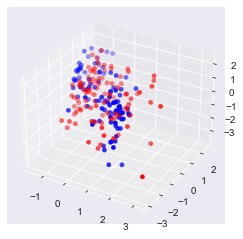

In [11]:
# Visualize the reduced data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_scaled_happy["acousticness"], df_scaled_happy["energy"], df_scaled_happy["loudness"], linewidth=0.2, color = "red")
ax.scatter(df_scaled_sad["acousticness"], df_scaled_sad["energy"], df_scaled_sad["loudness"], linewidth=0.2, color = "blue")
plt.show()

In [12]:
# #List Hyperparameters that we want to tune.
# leaf_size = list(range(1,50))
# n_neighbors = list(range(1,30))
# p=[1,2]
# weights = ['uniform', 'distance']
# metric = ['euclidean', 'manhattan', 'minkowski']
# #Convert to dictionary
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, weights=weights, metric=metric)
# #Create new KNN object
# knn_2 = KNeighborsClassifier()
# #Use GridSearch
# clf = GridSearchCV(knn_2, hyperparameters, cv=10)
# #Fit the model

# # best_model = clf.fit(reduced_combined, y)
# # for i in range (2,6):
# #     best_model = clf.fit(train_x[i], train_y[i])
# #     #Print The value of best Hyperparameters
# #     print("# input features:", i)
# #     print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# #     print('Best p:', best_model.best_estimator_.get_params()['p'])
# #     print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
# #     print('')

# best_model = clf.fit(train_x[5], train_y[5])
# #Print The value of best Hyperparameters
# print("# input features:", 5)
# print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
# print('Best weights:', best_model.best_estimator_.get_params()['weights'])
# print('Best metric:', best_model.best_estimator_.get_params()['metric'])
# print('')

k = 4
2 features: 0.8666666666666667
3 features: 0.8333333333333334
4 features: 0.9166666666666666
5 features: 0.95


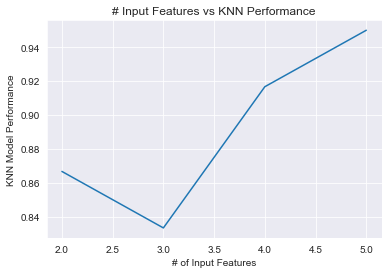

In [28]:
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_performances = []
# Find k value = we know there are 2 groups
#k = math.floor(math.sqrt(len(y_train))/2)
k = 4
print("k =", k)

# Train model
for i in range(2,6):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_x[i], train_y[i])

    # Make predictions
    prediction = knn.predict(test_x[i])
    print(i, "features:", printPerformance(prediction, test_y[i]))
    knn_performances.append(printPerformance(prediction, test_y[i]))

plt.figure()
plt.plot([2, 3, 4, 5], knn_performances)
plt.title('# Input Features vs KNN Performance')
plt.xlabel('# of Input Features')
plt.ylabel('KNN Model Performance')
plt.show()

# LDA & QDA

In [14]:
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# # define model
# model = LinearDiscriminantAnalysis()
# # define model evaluation method
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define grid
# grid = dict()
# grid['solver'] = ['svd', 'lsqr', 'eigen']
# # define search
# search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# for i in range(2,6):
#     # perform the search
#     results = search.fit(x_train[i], y_train[i])
#     # summarize
#     print("# input features:", i)
#     print('Mean Accuracy: %.3f' % results.best_score_)
#     print('Config: %s' % results.best_params_)
#     print('')


# # define model
# model2 = LinearDiscriminantAnalysis(solver='lsqr')
# # define model evaluation method
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define grid
# grid = dict()
# grid['shrinkage'] = np.arange(0, 1, 0.01)
# # define search
# search = GridSearchCV(model2, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# for i in range(2,6):
#     # perform the search
#     results = search.fit(x_train[i], y_train[i])
#     # summarize
#     print("# input features:", i)
#     print('Mean Accuracy: %.3f' % results.best_score_)
#     print('Config: %s' % results.best_params_)
#     print('')

In [15]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics

# estimator_3 = QuadraticDiscriminantAnalysis()
# parameters_3 = {
#     'reg_param': (0, 0.00001, 0.0001, 0.001, 0.01, 0.1), 
#     'store_covariance': (True, False),
#     'tol': (0.0001, 0.001,0.01, 0.1), 
#                    }
# # with GridSearch
# grid_search_qda = GridSearchCV(
#     estimator=estimator_3,
#     param_grid=parameters_3,
#     scoring = 'accuracy',
#     n_jobs = -1,
#     cv = 5
# )

# qda_1=grid_search_qda.fit(train_x[2], train_y[2])
# y_pred_7 =qda_1.predict(test_x[2])

# qda_2=grid_search_qda.fit(train_x[3], train_y[3])
# y_pred_8 =qda_2.predict(test_x[3])

# qda_3=grid_search_qda.fit(train_x[4], train_y[4])
# y_pred_9 =qda_3.predict(test_x[4])

# qda_4=grid_search_qda.fit(train_x[5], train_y[5])
# y_pred_10 =qda_3.predict(test_x[5])

# print('Accuracy Score - QDA - Poly = 1:', metrics.accuracy_score(test_y[2], y_pred_7)) 
# print('Accuracy Score - QDA - Poly = 2:', metrics.accuracy_score(test_y[3], y_pred_8)) 
# print('Accuracy Score - QDA - Poly = 3:', metrics.accuracy_score(test_y[4], y_pred_9))
# print('Accuracy Score - QDA - Poly = 3:', metrics.accuracy_score(test_y[5], y_pred_10))

# print(grid_search_qda.best_params_ )

LDA Performance:
2 features: 0.8333333333333334
3 features: 0.8333333333333334
4 features: 0.8666666666666667
5 features: 0.8666666666666667

QDA Performance:
2 features: 0.85
3 features: 0.8333333333333334
4 features: 0.9333333333333333
5 features: 0.9166666666666666


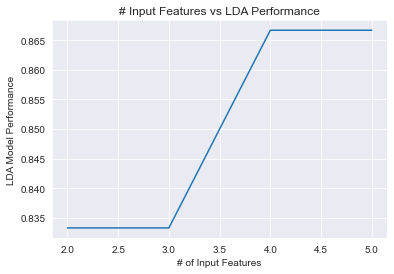

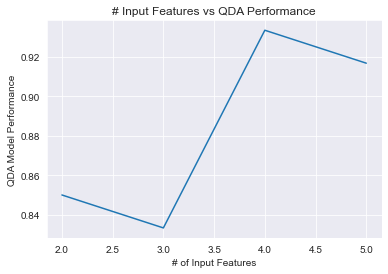

In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

lda_performances = []
qda_performances = []

print("LDA Performance:")
# Train model
for i in range(2,6):
    lda_train_x = np.array(train_x[i])
    lda_train_y = np.array(train_y[i])
    lda_test_x = np.array(test_x[i])
    
    clf = LinearDiscriminantAnalysis()
    clf.fit(lda_train_x, lda_train_y)
    lda_prediction = clf.predict(lda_test_x)
    print(i, "features:", printPerformance(lda_prediction, test_y[i]))
    lda_performances.append(printPerformance(lda_prediction, test_y[i]))

print("\nQDA Performance:")
# Train model
for i in range(2,6):
    qda_train_x = np.array(train_x[i])
    qda_train_y = np.array(train_y[i])
    qda_test_x = np.array(test_x[i])
    
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(qda_train_x, qda_train_y)
    qda_prediction = clf.predict(qda_test_x)
    print(i, "features:", printPerformance(qda_prediction, test_y[i]))
    qda_performances.append(printPerformance(qda_prediction, test_y[i]))

    
plt.figure()
plt.plot([2, 3, 4, 5], lda_performances)
plt.title('# Input Features vs LDA Performance')
plt.xlabel('# of Input Features')
plt.ylabel('LDA Model Performance')
plt.show()

plt.figure()
plt.plot([2, 3, 4, 5], qda_performances)
plt.title('# Input Features vs QDA Performance')
plt.xlabel('# of Input Features')
plt.ylabel('QDA Model Performance')
plt.show()

# Logistic Regression

Logistic Regression:
2 features: 0.8333333333333334
3 features: 0.8333333333333334
4 features: 0.8333333333333334
5 features: 0.8666666666666667


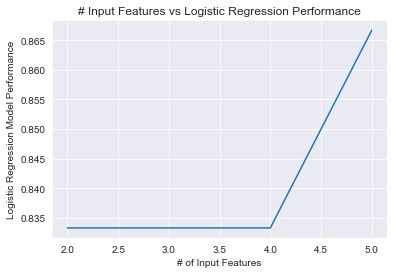

In [17]:
from sklearn.linear_model import LogisticRegression
logreg_performances = []

print("Logistic Regression:")
# Train model
for i in range(2,6):
    lr = LogisticRegression(random_state=0).fit(train_x[i], train_y[i])

    # Make predictions
    prediction = lr.predict(test_x[i])
    print(i, "features:", printPerformance(prediction, test_y[i]))
    logreg_performances.append(printPerformance(prediction, test_y[i]))
    

plt.figure()
plt.plot([2, 3, 4, 5], logreg_performances)
plt.title('# Input Features vs Logistic Regression Performance')
plt.xlabel('# of Input Features')
plt.ylabel('Logistic Regression Model Performance')
plt.show()

Logistic Regression:
2 features: 0.8
3 features: 0.7666666666666667
4 features: 0.75
5 features: 0.7333333333333333


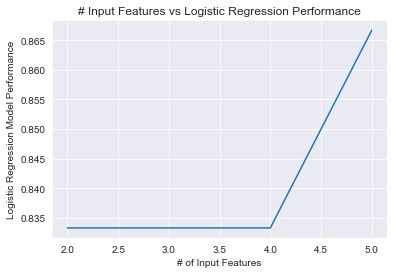

In [31]:
from sklearn.tree import DecisionTreeClassifier
logreg2_performances = []
print("Logistic Regression:")
# Train model
for i in range(2,6):
    dt = DecisionTreeClassifier(max_depth=30).fit(train_x[i], train_y[i])

    # Make predictions
    prediction = dt.predict(test_x[i])
    print(i, "features:", printPerformance(prediction, test_y[i]))
    logreg2_performances.append(printPerformance(prediction, test_y[i]))

plt.figure()
plt.plot([2, 3, 4, 5], logreg_performances)
plt.title('# Input Features vs Logistic Regression Performance')
plt.xlabel('# of Input Features')
plt.ylabel('Logistic Regression Model Performance')
plt.show()